In [2]:
import sys
sys.path.append('JetTagging')
sys.path.append('JetTagging/src')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.Preprocessing.JetPreprocessing import PreprocessingJetImages
from src.Preprocessing.LabelsGeneration import create_jet_labels_one_column_per_category
from sklearn.utils import shuffle
from keras.models import Sequential, load_model
from utilities.utilities import save_model

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [4]:
data_gluon_train = pd.read_csv("../Data/Trainning/g_jets.csv", header=None)
data_quark_train = pd.read_csv("../Data/Trainning/q_jets.csv", header=None)


data_gluon_val = pd.read_csv("../Data/Validation/g_jets.csv", header=None)
data_quark_val = pd.read_csv("../Data/Validation/q_jets.csv", header=None)


data_gluon_test = pd.read_csv("../Data/Test/g_jets.csv", header=None)
data_quark_test = pd.read_csv("../Data/Test/q_jets.csv", header=None)


In [5]:
pix = 16
lim = 0.4
jet_image_processing = PreprocessingJetImages(phi_range=(-lim, lim), eta_range=(-lim, lim), n_bins_phi=pix, n_bins_eta=pix)

In [6]:
gluon_images_train = jet_image_processing.transform(X=data_gluon_train.to_numpy())
quark_images_train = jet_image_processing.transform(X=data_quark_train.to_numpy())


gluon_images_val = jet_image_processing.transform(X=data_gluon_val.to_numpy())
quark_images_val = jet_image_processing.transform(X=data_quark_val.to_numpy())


gluon_images_test = jet_image_processing.transform(X=data_gluon_test.to_numpy())
quark_images_test = jet_image_processing.transform(X=data_quark_test.to_numpy())


In [7]:
#nesta ordem 

all_jet_images_train = np.vstack([gluon_images_train, quark_images_train])
all_jet_images_val = np.vstack([gluon_images_val, quark_images_val])
all_jet_images_test = np.vstack([gluon_images_test, quark_images_test])

In [8]:
### to indo de 0 a len(gluons)
### depois indo de len(gluons) até len(all_jets)


jet_labels_train = create_jet_labels_one_column_per_category([(0, len(gluon_images_train) -1), (len(gluon_images_train)  , len(all_jet_images_train) - 1)])
jet_labels_val = create_jet_labels_one_column_per_category([(0, len(gluon_images_val)-1 ), (len(gluon_images_val) , len(all_jet_images_val) - 1)])
jet_labels_test = create_jet_labels_one_column_per_category([(0, len(gluon_images_test) -1), (len(gluon_images_test)  , len(all_jet_images_test) - 1)]) 

In [7]:
x, y = shuffle(all_jet_images_train, jet_labels_train, random_state = 0)
vx, vy = shuffle(all_jet_images_val, jet_labels_val, random_state = 0)
tx, ty = shuffle(all_jet_images_test, jet_labels_test, random_state = 0)

x = x.reshape(-1,pix,pix,1)
vx = vx.reshape(-1,pix,pix,1)
tx = tx.reshape(-1,pix,pix,1)

In [8]:
regularization_rate = 10**(-8)
dropout_rate = 0.3

model = Sequential()
model.add(Input(shape=(pix,pix,1)))

model.add(Conv2D(filters = 128 , kernel_size=(5, 5), padding = "same", activation='relu',kernel_regularizer=l2(regularization_rate)))
model.add(MaxPool2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters = 128 , kernel_size=(5, 5), padding = "same", activation='relu',kernel_regularizer=l2(regularization_rate)))
model.add(MaxPool2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Dropout(dropout_rate))

model.add(Conv2D(filters = 64 , kernel_size=(3, 3), padding = "same", activation='relu',kernel_regularizer=l2(regularization_rate)))
model.add(MaxPool2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Dropout(dropout_rate))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(regularization_rate)))
model.add(Dropout(dropout_rate))

model.add(Dense(2, activation='softmax'))


learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy','auc'])

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [ModelCheckpoint(
        filepath = "model/QG_Tag_Model_3.keras",
        save_best_only=True,
        monitor = 'val_loss',
                    )]

#foi uma função q achei pra salvar umas infos de maneira mais fácil ( peguei tudo dum tutorial )
history = model.fit(
    x, y,
    epochs = 50,
    validation_data = (vx, vy),
    callbacks = callbacks,
    batch_size = 128 
)

1964/1964 ━━━━━━━━━━━━━━━━━━━━ 285s 145ms/step - accuracy: 0.7845 - auc: 0.8604 - loss: 0.4675 - val_accuracy: 0.7839 - val_auc: 0.8622 - val_loss: 0.4654
Epoch 33/50
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 278s 142ms/step - accuracy: 0.7852 - auc: 0.8605 - loss: 0.4673 - val_accuracy: 0.7853 - val_auc: 0.8642 - val_loss: 0.4620
Epoch 34/50
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 274s 139ms/step - accuracy: 0.7854 - auc: 0.8608 - loss: 0.4667 - val_accuracy: 0.7884 - val_auc: 0.8671 - val_loss: 0.4571
Epoch 35/50
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 273s 139ms/step - accuracy: 0.7849 - auc: 0.8602 - loss: 0.4678 - val_accuracy: 0.7828 - val_auc: 0.8618 - val_loss: 0.4653
Epoch 36/50
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 273s 139ms/step - accuracy: 0.7856 - auc: 0.8612 - loss: 0.4664 - val_accuracy: 0.7740 - val_auc: 0.8521 - val_loss: 0.4817
Epoch 37/50
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 258s 131ms/step - accuracy: 0.7852 - auc: 0.8604 - loss: 0.4673 - val_accuracy: 0.7848 - val_auc: 0.8622 - val_loss: 0.4660
Epoch 38/5

In [12]:
save_model(model=model,history=history,model_name="QG_Tag_Model_3")

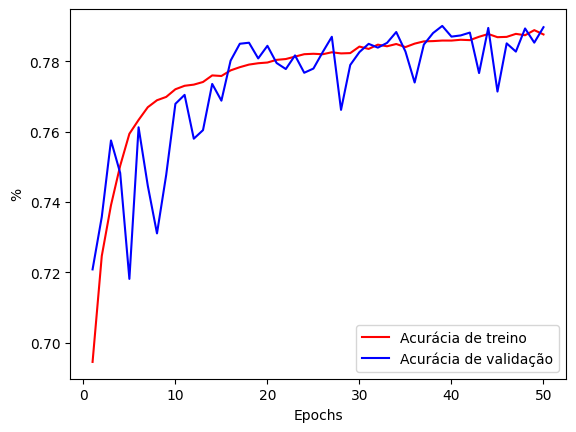

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,len(acc) + 1)
plt.figure()
plt.plot(epochs, acc,'r',label = 'Acurácia de treino')
plt.plot(epochs, val_acc,'b',label = 'Acurácia de validação')
plt.xlabel("Epochs")
plt.ylabel("%")
plt.legend()
plt.show()

1631/1631 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step


TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

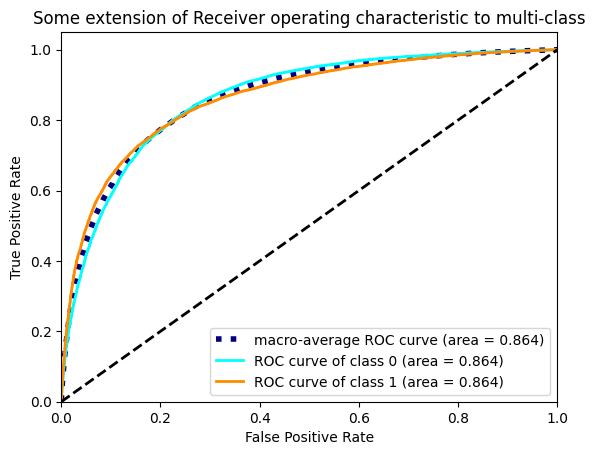

In [15]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

#model = load_model('QG_Tag_Model_DataNew.keras')
y_pred = model.predict(tx)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ty[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig()
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve QG-Tagging')
plt.legend(loc="lower right")
plt.savefig('figstrabIA/CurvaRoc.png')
plt.show()